### Predicting Depth with robust Random Forest Method

In [1]:
# Install packages
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Prepare dataset
tabel = pd.read_excel('J:\Studio De Voogt\Specialists & NA\Feadship Database\Feadship Python\JOSHA_workingstudent_2024\Main Dimensions Depth\Main dimensions Cleaned.xlsx')
tabel = tabel.dropna(subset=['Length Over All', 'Draught Design Deadweight', 'Depth', 'Beam Moulded']) #Remove missing values

# Show dataframe
tabel.head()

,Number,Yard,Length Over All,Draught Design Deadweight,Depth,Beam Moulded
0,DN3423,NaN,128.8,6.00,11.55,22.50
1,YN831 DN3365,"Royal van Lent, Amsterdam",143.5,5.95,11.35,20.00
2,DN3331,NaN,136.0,5.83,9.93,19.75
3,DN2631,NaN,180.0,5.80,12.90,22.50
4,DN3403,NaN,131.0,5.60,11.10,21.20


In [3]:
# Rename variables
Loa = tabel['Length Over All']
Tfull = tabel['Draught Design Deadweight']
D = tabel['Depth']
Bmld = tabel['Beam Moulded']

In [4]:
# Define variables for Random Forest
x = tabel.loc[:, ~tabel.columns.isin(['Number', 'Yard', 'Depth'])]
x = sm.add_constant(x)
y = D

### Random Forest Model: without outliers

In [5]:
# Prepare data: split dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42) # Use 20% for testing and 80% for training

#Install package
from sklearn.ensemble import RandomForestRegressor

# Initializing the Random Forest Regression model with 100 decision trees, max depth is 10 layers
rf = RandomForestRegressor(n_estimators = 100, max_depth=10, random_state = 42) # Random_state ensures consistency of the output results

Cross-validation for training model performance:

In [6]:
# Install package
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation for the Random Forest model
cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='r2')

print("The results of the cross-validation:")
print(f'R² scores with 5-folded cross-validation: {cv_scores}')
print(f'Average R² score: {np.mean(cv_scores)}')

n = x.shape[0]  # Number observations in the dataset
p = x.shape[1]  # Number observations in the dataset

adjusted_r2_scores = [1 - ((1 - r2) * (n - 1) / (n - p - 1)) for r2 in cv_scores]
print(f'Adjusted R² scores of the cross-validation: {adjusted_r2_scores}')
print(f'Average adjusted R² score: {np.mean(adjusted_r2_scores)}')

The results of the cross-validation:
R² scores with 5-folded cross-validation: [0.95894554 0.95643253 0.972474   0.96577609 0.96030364]
Average R² score: 0.9627863620071636
Adjusted R² scores of the cross-validation: [0.9587845456093674, 0.9562616819279394, 0.9723660506348213, 0.9656418809527053, 0.9601479717346545]
Average adjusted R² score: 0.9626404261718976


Fitting the Random Forest model:

In [7]:
# Fitting the Random Forest Regression model to the data
rf_model = rf.fit(x_train, y_train)

# R² for the trainingsset --> is expected to be close to 1
y_train_pred = rf_model.predict(x_train)
r2_train = r2_score(y_train, y_train_pred)
print(f'R² op de trainingset: {r2_train}')

# R² for the testset --> more relevant
y_test_pred = rf_model.predict(x_test)
r2_test = r2_score(y_test, y_test_pred)
print(f'R² op de testset: {r2_test}')

# MSE and RMSE for the testset
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
print(f'Mean Squared Error (MSE) op de testset: {mse_test}')
print(f'Root Mean Squared Error (RMSE) op de testset: {rmse_test}')

R² op de trainingset: 0.993157665760146
R² op de testset: 0.9600010259911698
Mean Squared Error (MSE) op de testset: 0.09956172827405133
Root Mean Squared Error (RMSE) op de testset: 0.3155340366332154


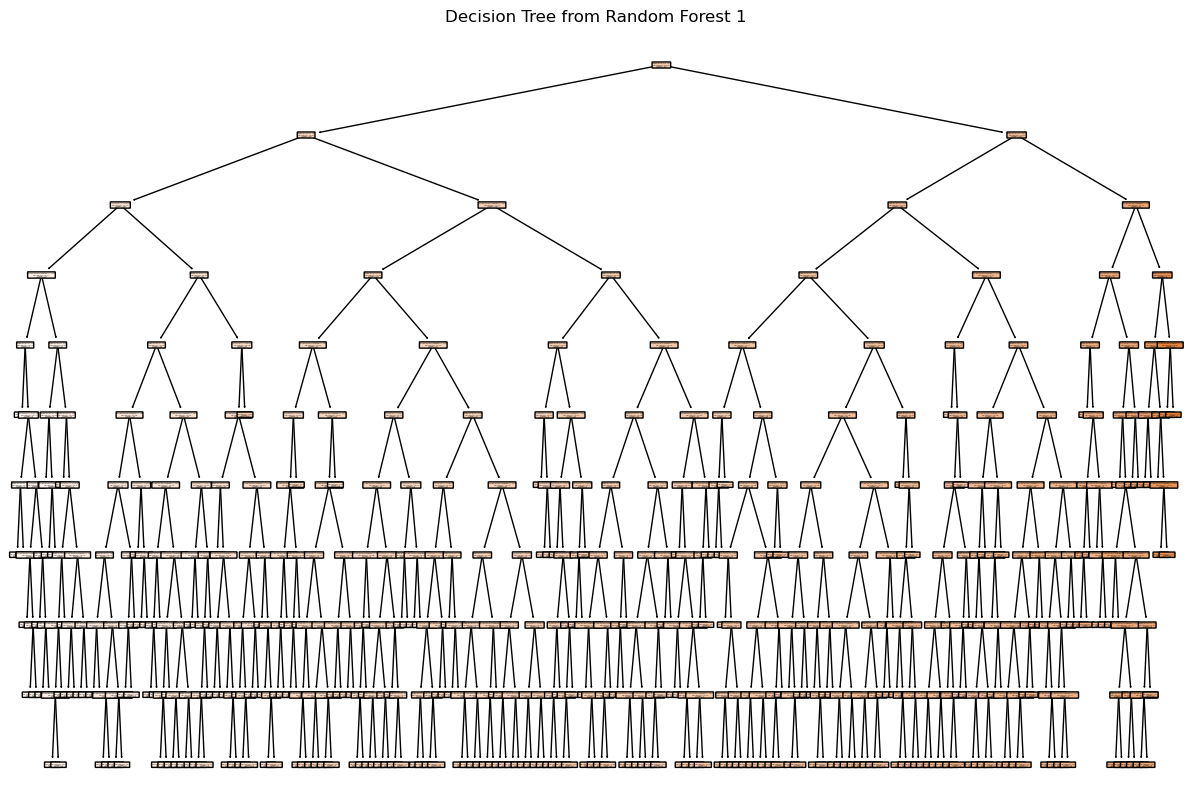

In [8]:
# Visualize Random Forest example tree (in reality there are 100 trees)
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], feature_names=x.columns, filled=True, rounded=True)
plt.title("Decision Tree from Random Forest 1")
plt.savefig('random tree out1.pdf')
#plt.show()

Plot to show predictive performance

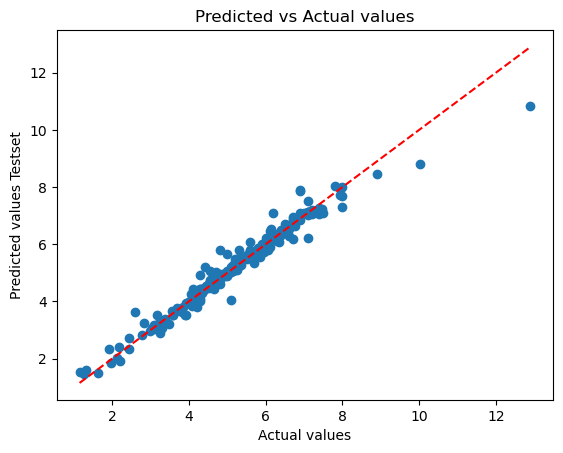

In [9]:
# Plot Actual vs Predicted values TESTset
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual values')
plt.ylabel('Predicted values Testset')
plt.title('Predicted vs Actual values')
plt.show()

#### Extract importances for each variable (weights)

In [10]:
# Extract list of importance weights for variables
importances = list(rf.feature_importances_)

# Redefine X since it is a dataframe
indp_variables = x.columns if hasattr(x, 'columns') else x

 # List of tuples: combine variables with importances
x_importances = [(indp_variable, round(importance, 2)) for indp_variable, importance in zip(indp_variables, importances)]
x_importances = sorted(x_importances, key=lambda x: x[1], reverse=True) # Sort to most important first

# Print out the independant variables and their importance
for indp_variable, importance in x_importances:
    print(f'Variable: {indp_variable:20} Importance: {importance}')

Variable: Beam Moulded         Importance: 0.8
Variable: Length Over All      Importance: 0.11
Variable: Draught Design Deadweight Importance: 0.1
Variable: const                Importance: 0.0


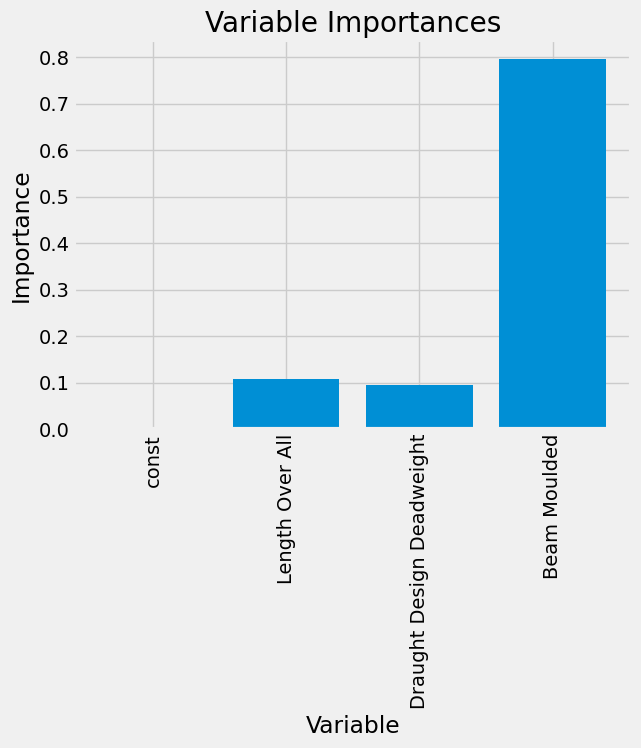

In [11]:
#Set x_values as range on x-axis
x_values = list(range(len(importances)))

# Create boxplot for variable importances
plt.style.use('fivethirtyeight')
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, x, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
plt.show()

All Predictions for Depth in table

In [12]:
# All predictions for rf
predictions_rf = rf.predict(x)
tabel['Predicted_Depth_RF'] = predictions_rf
tabel['residual_RF'] = y - predictions_rf
tabel['residual_RF %'] = ((predictions_rf -y) / y)*100
pd.options.display.max_rows = None
tabel.head()

,Number,Yard,Length Over All,Draught Design Deadweight,Depth,Beam Moulded,Predicted_Depth_RF,residual_RF,residual_RF %
0,DN3423,NaN,128.8,6.00,11.55,22.50,11.3440,0.2060,-1.783550
1,YN831 DN3365,"Royal van Lent, Amsterdam",143.5,5.95,11.35,20.00,10.8929,0.4571,-4.027313
2,DN3331,NaN,136.0,5.83,9.93,19.75,10.3008,-0.3708,3.734139
3,DN2631,NaN,180.0,5.80,12.90,22.50,10.8464,2.0536,-15.919380
4,DN3403,NaN,131.0,5.60,11.10,21.20,10.7108,0.3892,-3.506306


### Predict Depth: fill in your specific values here!

In [13]:
# Fill in the green numbers that correspond to the variable names in red preceding them:
############################

x_new_data = {
    'const': [0], 
    'Length Over All': [123],
    'Draught Design Deadweight': [5.5],
    'Beam Moulded': [19],
}

# Create a DataFrame for X_new
x_new = pd.DataFrame(x_new_data)
print(x_new)

# Predict the target values (y) using the trained model
y_new_pred_rf = rf.predict(x_new)
print('This will be the predicted Depth according to the trained Random Forest model:', y_new_pred_rf)

   const  Length Over All  Draught Design Deadweight  Beam Moulded
0      0              123                        5.5            19
This will be the predicted Depth according to the trained Random Forest model: [9.2601]
